In [ ]:
! pip install imblearn
! pip install xgboost
! pip install lightgbm
from IPython.display import clear_output
import time

clear_output()
time.sleep(0.1)

In [ ]:
! mkdir -p dataset/csvs/
! mkdir -p plots/

In [ ]:
import os
import sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
dataset = pd.read_csv("dataset/csvs/all_features.csv", index_col=0)

#### Data Cleaning

In [ ]:
print(f"(N(NON-CHILL), N(CHILL)): {(dataset['label']=='NON-CHILL').sum(), len(dataset)-(dataset['label']=='NON-CHILL').sum()}")
N_SAMPLES = dataset.shape[0]
print(f"Dataset Size: {dataset.shape}")

(N(NON-CHILL), N(CHILL)): (8700, 3495)
Dataset Size: (12195, 39)


In [ ]:
NAN_VALS_DF = dataset.isna().sum()
EXTREME_NANS = NAN_VALS_DF[NAN_VALS_DF>int(0.1*N_SAMPLES)]
print(EXTREME_NANS/(dataset.shape[0]*dataset.shape[1]))
print(f"Total %: {(EXTREME_NANS/(dataset.shape[0]*dataset.shape[1])).sum():.2f}%")
print(" ")
print(f"Dataset Size: {dataset.shape}")
NAN_VALS_DF = dataset.isna().sum()
print(f"NO NAN VALS/DATASET_SIZE: {NAN_VALS_DF.sum()}/{dataset.shape[0]*dataset.shape[1]} = {NAN_VALS_DF.sum()/(dataset.shape[0]*dataset.shape[1]):.2f}%")

SDBB                     0.016882
RR_RMSSD                 0.024234
SDSD                     0.024234
CRC_coherence            0.025641
phasic_amplitude_mean    0.009920
phasic_amplitudes_std    0.009920
phasic_risetime_mean     0.009920
phasic_risetime_std      0.009920
phasic_recovery_mean     0.007920
phasic_recovery_std      0.007920
dtype: float64
Total %: 0.15%
 
Dataset Size: (12195, 39)
NO NAN VALS/DATASET_SIZE: 71404/475605 = 0.15%


In [ ]:
dataset = dataset.drop(["CRC_coherence"], axis=1)

num_cols = dataset.select_dtypes(include=["number"]).columns
labels = dataset["label"].unique()

for label in labels:
  df = dataset[num_cols].fillna(dataset[num_cols].mean())
  dataset.loc[dataset["label"] == label, num_cols] = df

In [ ]:
NAN_VALS_DF = dataset.isna().sum()
EXTREME_NANS = NAN_VALS_DF[NAN_VALS_DF>int(0.1*N_SAMPLES)]
print(EXTREME_NANS/(dataset.shape[0]*dataset.shape[1]))
print(f"Total %: {(EXTREME_NANS/(dataset.shape[0]*dataset.shape[1])).sum():.2f}%")
print(" ")
print(f"Dataset Size: {dataset.shape}")
NAN_VALS_DF = dataset.isna().sum()
print(f"NO NAN VALS/DATASET_SIZE: {NAN_VALS_DF.sum()}/{dataset.shape[0]*dataset.shape[1]} = {NAN_VALS_DF.sum()/(dataset.shape[0]*dataset.shape[1]):.2f}%")

Series([], dtype: float64)
Total %: 0.00%
 
Dataset Size: (12195, 38)
NO NAN VALS/DATASET_SIZE: 0/463410 = 0.00%


In [ ]:
dataset = dataset.drop(["HRV_LF", "RRV_LF"], axis=1)

#### Quick EDA Based On Preliminary EDA

In [ ]:
dataset.head()

,id,stimuli,label,mean_HR,HRV,mean_NN,std_NN,median_NN,HR_RMSSD,HRV_HF,...,EDA_skew,EDA_kurtosis,phasic_amplitude_mean,phasic_amplitudes_std,phasic_risetime_mean,phasic_risetime_std,phasic_recovery_mean,phasic_recovery_std,phasic_domnt_freq,EDA_SCL
0,5002_5_0,post_rest,NON-CHILL,63.360979,1.029105,0.9472,0.016522,0.950,0.019131,1.440471e-33,...,0.435711,-1.104652,0.005043,0.000540,0.852704,0.138496,4.363955,0.492432,0.166667,0.126298
1,5002_5_1,post_rest,NON-CHILL,59.005010,0.680279,1.0170,0.013304,1.010,0.018511,0.000000e+00,...,-0.153800,-1.525659,0.000041,0.000000,0.152000,0.000000,3.910000,0.000000,0.333333,0.147703
2,5002_5_2,post_rest,NON-CHILL,59.446527,1.574107,1.0100,0.028538,1.014,0.039648,2.536911e-34,...,0.237067,-1.179744,0.002686,0.002688,1.024000,0.894374,3.428000,2.526000,0.333333,0.176089
3,5002_5_3,post_rest,NON-CHILL,58.886034,1.522026,1.0196,0.028939,1.014,0.035805,1.447959e-34,...,-0.313230,-1.129965,0.005043,0.000540,0.852704,0.138496,4.363955,0.492432,0.000000,0.229555
4,5002_5_4,post_rest,NON-CHILL,63.809217,7.038918,0.9504,0.100665,0.970,0.101010,1.197820e-33,...,-0.290256,-1.369992,0.005043,0.000540,0.852704,0.138496,4.363955,0.492432,0.000000,0.287336


In [ ]:
X = dataset.drop(["label", "id", "stimuli"], axis=1)
y = dataset["label"]
y = y.apply(lambda x: 0 if x == "NON-CHILL" else 1)

dataset = pd.concat([X, y], axis=1)

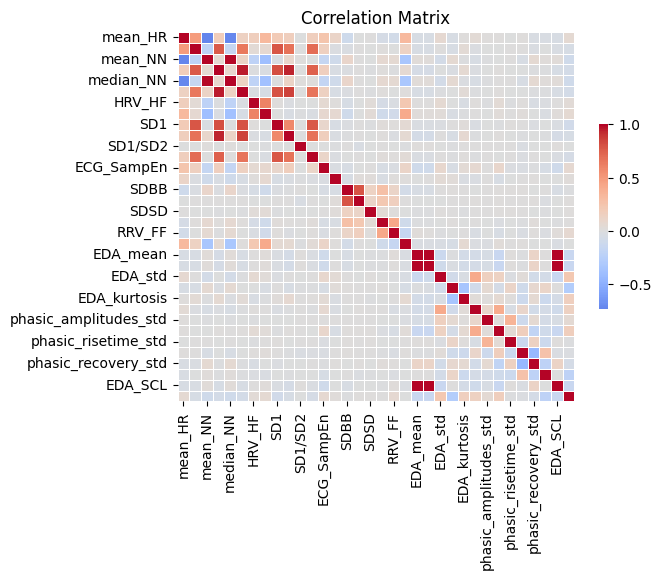

In [ ]:
corr_matx = dataset.corr()

sns.heatmap(corr_matx, annot=False, cmap="coolwarm", center=0, fmt=".1f", linewidths=0.5, cbar_kws={"shrink": 0.5})
plt.title("Correlation Matrix")
plt.show()

#### Most Correlated Features with Target

In [ ]:
features = dataset.columns[:-1]

target_correlated_features = corr_matx["label"]
target_correlated_features = target_correlated_features[abs(target_correlated_features) > 0.05]
target_correlated_features = target_correlated_features.drop("label")
print(target_correlated_features)
target_correlated_features = target_correlated_features.index

mean_HR                  0.060553
HRV                     -0.051273
mean_NN                 -0.090381
std_NN                  -0.072936
median_NN               -0.092842
HR_RMSSD                -0.072793
HRV_FF                   0.057501
SD1                     -0.086714
SD2                     -0.055056
ellipse_area            -0.061201
ECG_SampEn               0.072353
RRV_FF                   0.071801
EDA_mean                -0.146861
EDA_median              -0.139476
EDA_std                  0.228278
EDA_skew                -0.275066
EDA_kurtosis             0.158544
phasic_amplitude_mean    0.146283
phasic_risetime_mean     0.162532
phasic_recovery_std     -0.066104
phasic_domnt_freq       -0.217411
EDA_SCL                 -0.147705
Name: label, dtype: float64


### Modelling

In [ ]:
np.random.seed(42)

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

random_sampler = RandomUnderSampler(sampling_strategy=0.5)
X, y = random_sampler.fit_resample(X, y)

# smote = SMOTE(sampling_strategy=0.5)
# X, y = smote.fit_resample(X, y)

imblearn_ = "underSample"


from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, recall_score, precision_score
from sklearn.metrics import roc_auc_score, roc_curve, matthews_corrcoef
from imblearn.metrics import geometric_mean_score

In [ ]:
# @title Checkpointing Models Performance

models_performance = pd.DataFrame(columns=["Model", "SearchCV", "folds", "HyperParams", "Train-Accuracy", "Test-Accuracy", "F1-Score", "Recall", "Precision", "ROC_AUC",])

def save_model_metrics(name, search, cv, train, test, model, threshold=0.5, df=models_performance):

  x_train, y_train = train
  x, y = test

  y_pred = model.best_estimator_.predict_proba(x)
  y_pred = y_pred[:, 1] > threshold
  y_probs = model.best_estimator_.predict_proba(x)

  model_details = pd.DataFrame([{
    "Model": name,
    "SearchCV": search,
    "folds": cv,
    "HyperParams": model.best_params_,
    "Train-Accuracy": accuracy_score(y_train, model.best_estimator_.predict_proba(x_train)[:,1] > threshold),
    "Test-Accuracy": accuracy_score(y, y_pred),
    "F1-Score": f1_score(y, y_pred),
    "Recall": recall_score(y, y_pred),
    "Precision": precision_score(y, y_pred),
    "ROC_AUC": roc_auc_score(y, y_probs[:,1]),
    "mthw_corr": matthews_corrcoef(y, y_pred),
    "geometric_mean": geometric_mean_score(y, y_pred),
    "threshold": threshold
    }])

  df = pd.concat([df, model_details], ignore_index=True)
  return df

#### Features Engineering

#### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000)
log_params = {
    "C": np.logspace(-4, 4, 20),
    "solver": ["liblinear"],
    "penalty": ["l1", "l2"],
    "class_weight": ["balanced"]
}

fois = X.columns
n_folds = 5
scoring_ = ["f1", "precision", "recall", "accuracy"]

grid_log_reg = GridSearchCV(log_reg, log_params, scoring=scoring_, refit="accuracy", cv=n_folds, n_jobs=-1, verbose=1)
grid_log_reg.fit(X_train[fois], y_train)
log_reg = grid_log_reg.best_estimator_
print(grid_log_reg.best_params_)

# rand_log_reg = RandomizedSearchCV(log_reg, log_params, scoring="f1", cv=n_folds, n_jobs=-1, verbose=1)
# rand_log_reg.fit(X_train[fois], y_train)
# log_reg = rand_log_reg.best_estimator_
# print(rand_log_reg.best_params_)

y_pred = log_reg.predict(X_test[fois])
y_proba = log_reg.predict_proba(X_test[fois])

train_acc = accuracy_score(y_train, log_reg.predict(X_train[fois]))
test_acc = accuracy_score(y_test, y_pred)

print(f"Train Accuracy: {train_acc}")
print(f"Test Accuracy: {test_acc}")

Fitting 5 folds for each of 40 candidates, totalling 200 fits
{'C': 3792.690190732246, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}
Train Accuracy: 0.7265140677157844
Test Accuracy: 0.7315212207916071


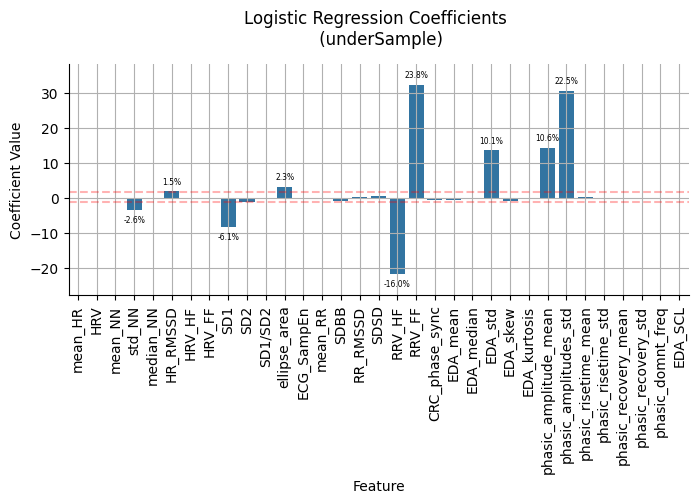

In [ ]:
log_reg_coefs = log_reg.coef_[0]
log_reg_coefs_percent = log_reg_coefs / np.abs(log_reg_coefs).sum() * 100
log_reg_intercept = log_reg.intercept_

plt.figure(figsize=(8, 3))
ax = sns.barplot(x=fois, y=log_reg_coefs)

# Add percentage labels on top of each bar
for i, (bar, percent) in enumerate(zip(ax.patches, log_reg_coefs_percent)):
    if abs(percent) < 1:
        continue
    ax.text(
        bar.get_x() + bar.get_width() / 2,  # X position (center of the bar)
        bar.get_height() + (bar.get_height()/abs(bar.get_height()))*1.5,  # Y position (top of the bar)
        f"{percent:.1f}%",  # Format percentage
        ha="center",
        va="bottom" if bar.get_height() > 0 else "top",  # Adjust for negative values
        fontsize=5.5,
        color="black"
    )

plt.ylabel("Coefficient Value")
plt.xlabel("Feature")
plt.axhline(y=0.05*max(log_reg_coefs), color="red", linestyle="--", alpha=0.3)
plt.axhline(y=0.05*min(log_reg_coefs), color="red", linestyle="--", alpha=0.3)
plt.xticks(rotation=90)
plt.ylim(log_reg_coefs.min()-6, log_reg_coefs.max()+6)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.grid()
plt.title(f"Logistic Regression Coefficients \n ({imblearn_})", y=1.05)
plt.savefig(f"plots/log_reg_coefs_{imblearn_}.png", bbox_inches="tight", pad_inches=0.2, dpi=300)

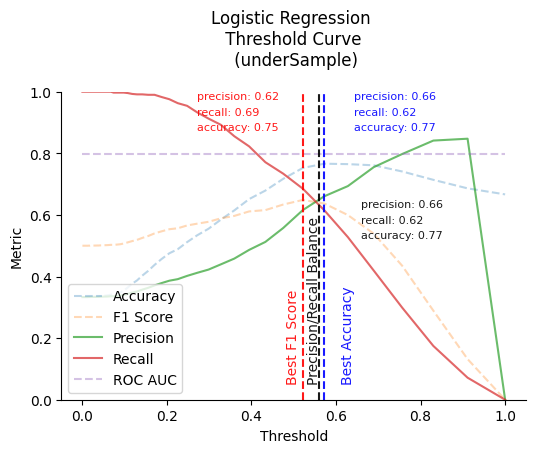

In [ ]:
y_pred = log_reg.predict_proba(X_test[fois])

brier_thresholds = []
brier_accs = []
brier_f1s = []
brier_precisions = []
brier_recalls = []
brier_roc_auc = []

for threshold in np.logspace(-4, 0, 100):
    y_pred_thresh = y_pred[:, 1] > threshold
    brier_thresholds.append(threshold)
    brier_accs.append(accuracy_score(y_test, y_pred_thresh))
    brier_f1s.append(f1_score(y_test, y_pred_thresh))
    brier_precisions.append(precision_score(y_test, y_pred_thresh))
    brier_recalls.append(recall_score(y_test, y_pred_thresh))
    brier_roc_auc.append(roc_auc_score(y_test, y_pred[:, 1]))

best_acc_threshold = brier_thresholds[np.argmax(brier_accs)]
best_f1_threshold = brier_thresholds[np.argmax(brier_f1s)]
idx = np.argmax(brier_f1s)

plt.figure(figsize=(6, 4))
plt.plot(brier_thresholds, brier_accs, label="Accuracy", linestyle="--", alpha=0.3)
plt.plot(brier_thresholds, brier_f1s, label="F1 Score", linestyle="--", alpha=0.3)
plt.plot(brier_thresholds, brier_precisions, label="Precision", alpha=0.7)
plt.plot(brier_thresholds, brier_recalls, label="Recall", alpha=0.7)
plt.plot(brier_thresholds, brier_roc_auc, linestyle="--", label="ROC AUC", alpha=0.4)

plt.axvline(x=brier_thresholds[np.argmax(brier_accs)], color=(0, 0, 1, 0.9), linestyle="--")
plt.text(best_acc_threshold+0.04, 0.05, "Best Accuracy", color=(0, 0, 1, 0.9), rotation=90, verticalalignment="bottom")
plt.axvline(x=brier_thresholds[np.argmax(brier_f1s)], color=(1, 0, 0, 0.9), linestyle="--")
plt.text(best_f1_threshold-0.04, 0.05, "Best F1 Score", color=(1, 0, 0, 0.9), rotation=90, verticalalignment="bottom")
plt.axvline(x=0.56, color=(0, 0, 0, 0.9), linestyle="--")
plt.text(0.53, 0.05, "Precision/Recall Balance", color=(0, 0, 0, 0.9), rotation=90, verticalalignment="bottom")
mtx = confusion_matrix(y_test, y_pred[:,1] > 0.56)

idx = np.argmin(np.abs(np.array(brier_thresholds) - 0.56))
plt.text(0.56+0.1, 0.65, "precision: {:.2f}".format(brier_precisions[idx]), color=(0, 0, 0, 0.9), rotation=0, verticalalignment="top", fontsize=8)
plt.text(0.56+0.1, 0.60, "recall: {:.2f}".format(brier_recalls[idx]), color=(0, 0, 0, 0.9), rotation=0, verticalalignment="top", fontsize=8)
plt.text(0.56+0.1, 0.55, "accuracy: {:.2f}".format(brier_accs[idx]), color=(0, 0, 0, 0.9), rotation=0, verticalalignment="top", fontsize=8)
idx = np.argmax(brier_f1s)
plt.text(best_f1_threshold-0.25, 1.00, "precision: {:.2f}".format(brier_precisions[idx]), color=(1, 0, 0, 0.9), rotation=0, verticalalignment="top", fontsize=8)
plt.text(best_f1_threshold-0.25, 0.95, "recall: {:.2f}".format(brier_recalls[idx]), color=(1, 0, 0, 0.9), rotation=0, verticalalignment="top", fontsize=8)
plt.text(best_f1_threshold-0.25, 0.90, "accuracy: {:.2f}".format(brier_accs[idx]), color=(1, 0, 0, 0.9), rotation=0, verticalalignment="top", fontsize=8)
idx = np.argmax(brier_accs)
plt.text(best_acc_threshold+0.07, 1.00, "precision: {:.2f}".format(brier_precisions[idx]), color=(0, 0, 1, 0.9), rotation=0, verticalalignment="top", fontsize=8)
plt.text(best_acc_threshold+0.07, 0.95, "recall: {:.2f}".format(brier_recalls[idx]), color=(0, 0, 1, 0.9), rotation=0, verticalalignment="top", fontsize=8)
plt.text(best_acc_threshold+0.07, 0.90, "accuracy: {:.2f}".format(brier_accs[idx]), color=(0, 0, 1, 0.9), rotation=0, verticalalignment="top", fontsize=8)

plt.ylim(0, 1)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.xlabel("Threshold")
plt.ylabel("Metric")
plt.title(f"Logistic Regression \n Threshold Curve \n ({imblearn_})", y=1.06)
plt.legend(loc="lower left")
# plt.grid()
plt.savefig(f"plots/log_reg_threshold_curve_{imblearn_}.png", bbox_inches="tight", pad_inches=0.2, dpi=300)

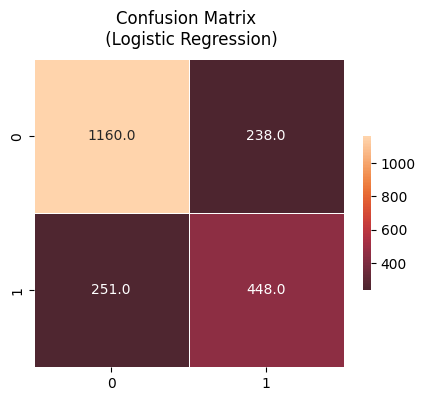

In [ ]:
plt.figure(figsize=(5,4))
sns.heatmap(mtx, annot=True, center=0, fmt=".1f", linewidths=0.5, cbar_kws={"shrink": 0.5})
plt.title("Confusion Matrix \n (Logistic Regression)", y=1.02)
plt.savefig("plots/ConfusionMatrix_LogReg.png", bbox_inches="tight", pad_inches=0.2, dpi=300)

In [ ]:
models_performance = save_model_metrics("LogReg", "GridSearch", n_folds, [X_train, y_train], [X_test, y_test], grid_log_reg, 0.56, models_performance)

#### RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rnd_for = RandomForestClassifier()
rnf_params = {
    "n_estimators": [300],
    "max_depth": [20],
    "min_samples_split": [2],
    "min_samples_leaf": [1],
    "bootstrap": [False],
    "criterion": ["gini"],
    "class_weight": ["balanced"],
}

fois = X.columns
n_folds = 5
scoring_ = ["f1", "precision", "recall", "accuracy"]

# grid_rnd_for = GridSearchCV(rnd_for, rnf_params, scoring=scoring_, refit="accuracy", cv=n_folds, n_jobs=-1, verbose=1)
# grid_rnd_for.fit(X_train[fois], y_train)
# rnd_for = grid_rnd_for.best_estimator_
# print(grid_rnd_for.best_params_)

rand_rnd_for = RandomizedSearchCV(rnd_for, rnf_params, scoring=scoring_, refit="accuracy", cv=n_folds, n_jobs=-1, verbose=1)
rand_rnd_for.fit(X_train[fois], y_train)
rnd_for = rand_rnd_for.best_estimator_
print(rand_rnd_for.best_params_)

y_pred = rnd_for.predict(X_test[fois])
y_proba = rnd_for.predict_proba(X_test[fois])

train_acc = accuracy_score(y_train, rnd_for.predict(X_train[fois]))
test_acc = accuracy_score(y_test, y_pred)

print(f"Train Accuracy: {train_acc}")
print(f"Test Accuracy: {test_acc}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20, 'criterion': 'gini', 'class_weight': 'balanced', 'bootstrap': False}
Train Accuracy: 1.0
Test Accuracy: 0.855030996661898


In [ ]:
rnd_for_fi = rnd_for.feature_importances_

plt.figure(figsize=(8, 3))

sns.barplot(x=fois, y=rnd_for_fi)
plt.axhline(y=0.05*max(rnd_for_fi), color="red", linestyle="--")
plt.axhline(y=0.05*min(rnd_for_fi), color="red", linestyle="--")
plt.xticks(rotation=90)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.grid()
plt.ylabel("Feature Importance")
plt.xlabel("Features")
plt.title(f"Random Forest Feature Importances \n ({imblearn_})")
plt.savefig(f"plots/rnd_for_fi_{imblearn_}.png", bbox_inches="tight", pad_inches=0.2, dpi=300)

In [ ]:
y_pred = rnd_for.predict_proba(X_test[fois])

brier_thresholds = []
brier_accs = []
brier_f1s = []
brier_precisions = []
brier_recalls = []
brier_roc_auc = []

for threshold in np.logspace(-4, 0, 100):
    y_pred_thresh = y_pred[:, 1] > threshold
    brier_thresholds.append(threshold)
    brier_accs.append(accuracy_score(y_test, y_pred_thresh))
    brier_f1s.append(f1_score(y_test, y_pred_thresh))
    brier_precisions.append(precision_score(y_test, y_pred_thresh))
    brier_recalls.append(recall_score(y_test, y_pred_thresh))
    brier_roc_auc.append(roc_auc_score(y_test, y_pred[:, 1]))

best_acc_threshold = brier_thresholds[np.argmax(brier_accs)]
best_f1_threshold = brier_thresholds[np.argmax(brier_f1s)]
idx = np.argmax(brier_f1s)

plt.figure(figsize=(6, 4))
plt.plot(brier_thresholds, brier_accs, label="Accuracy", linestyle="--", alpha=0.5)
plt.plot(brier_thresholds, brier_f1s, label="F1 Score", linestyle="--", alpha=0.5)
plt.plot(brier_thresholds, brier_precisions, label="Precision", alpha=0.7)
plt.plot(brier_thresholds, brier_recalls, label="Recall", alpha=0.7)
plt.plot(brier_thresholds, brier_roc_auc, linestyle="--", label="ROC AUC", alpha=0.4)

plt.axvline(x=brier_thresholds[np.argmax(brier_accs)], color=(0, 0, 1, 0.9), linestyle="--")
plt.text(best_acc_threshold+0.035, 0.05, "Best Accuracy", color=(0, 0, 1, 0.9), rotation=90, verticalalignment="bottom")
plt.axvline(x=brier_thresholds[np.argmax(brier_f1s)], color=(1, 0, 0, 0.9), linestyle="--")
plt.text(best_f1_threshold-0.04, 0.05, "Best F1 Score", color=(1, 0, 0, 0.9), rotation=90, verticalalignment="bottom")
plt.axvline(x=0.41, color=(0, 0, 0, 0.9), linestyle="--")
plt.text(0.36, 0.05, "Precision/Recall Balance", color=(0, 0, 0, 0.9), rotation=90, verticalalignment="bottom")


idx = np.argmin(np.abs(np.array(brier_thresholds) - 0.41))
plt.text(0.16, 0.70, "precision: {:.2f}".format(brier_precisions[idx]), color=(0, 0, 0, 0.9), rotation=0, verticalalignment="top", fontsize=8)
plt.text(0.16, 0.65, "recall: {:.2f}".format(brier_recalls[idx]), color=(0, 0, 0, 0.9), rotation=0, verticalalignment="top", fontsize=8)
plt.text(0.16, 0.60, "accuracy: {:.2f}".format(brier_accs[idx]), color=(0, 0, 0, 0.9), rotation=0, verticalalignment="top", fontsize=8)
idx = np.argmax(brier_accs)
plt.text(best_acc_threshold+0.05, 0.50, "precision: {:.2f}".format(brier_precisions[idx]), color=(0, 0, 1, 0.9), rotation=0, verticalalignment="top", fontsize=8)
plt.text(best_acc_threshold+0.05, 0.45, "recall: {:.2f}".format(brier_recalls[idx]), color=(0, 0, 1, 0.9), rotation=0, verticalalignment="top", fontsize=8)
plt.text(best_acc_threshold+0.05, 0.40, "accuracy: {:.2f}".format(brier_accs[idx]), color=(0, 0, 1, 0.9), rotation=0, verticalalignment="top", fontsize=8)

plt.ylim(0, 1)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.xlabel("Threshold")
plt.ylabel("Metric")
plt.title(f"Random Forest \n Threshold Curve \n ({imblearn_})", y=1.06)
plt.legend(loc="lower left")
# plt.grid()
plt.savefig(f"plots/random_forest_threshold_curve_{imblearn_}.png", bbox_inches="tight", pad_inches=0.2, dpi=300)

In [ ]:
models_performance = save_model_metrics("RandomForest", "RandomSearch", n_folds, [X_train, y_train], [X_test, y_test], rand_rnd_for, 0.41, models_performance)

#### SVM

In [ ]:
from sklearn.svm import SVC

svc = SVC()

svc_params = {
    "C": np.logspace(-4, 4, 20),
    "kernel": ["linear", "rbf"],
    "gamma": ["scale", "auto"],
    "class_weight": ["balanced"],
    "max_iter": np.arange(5000, 5500, 100),
    "probability": [True],
}

fois = X.columns
n_folds = 3
scoring_ = ["f1", "precision", "recall", "accuracy"]

# svc.fit(X_train[fois], y_train)

# grid_svc = GridSearchCV(svc, svc_params, scoring="f1", cv=n_folds, n_jobs=-1, verbose=1)
# grid_svc.fit(X_train[fois], y_train)
# svc = grid_svc.best_estimator_
# print(grid_svc.best_params_)

rnd_svc = RandomizedSearchCV(svc, svc_params, scoring=scoring_, refit="accuracy", cv=n_folds, n_jobs=-1, verbose=1)
rnd_svc.fit(X_train[fois], y_train)
svc = rnd_svc.best_estimator_
print(rnd_svc.best_params_)

y_pred = svc.predict(X_test[fois])
y_proba = svc.predict_proba(X_test[fois])

train_acc = accuracy_score(y_train, svc.predict(X_train[fois]))
test_acc = accuracy_score(y_test, y_pred)

print(f"Train Accuracy: {train_acc}")
print(f"Test Accuracy: {test_acc}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'probability': True, 'max_iter': 5200, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'C': 3792.690190732246}
Train Accuracy: 1.0
Test Accuracy: 0.9602327837051406


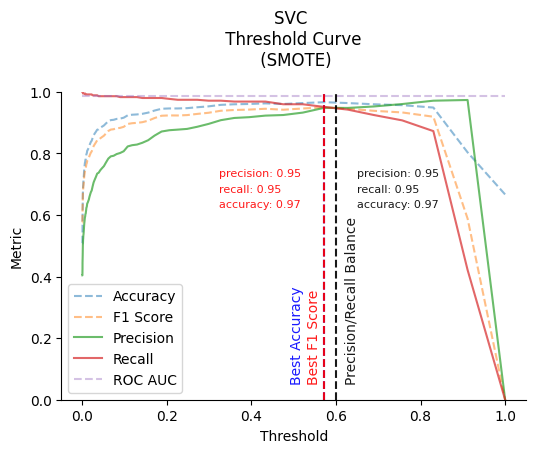

In [ ]:
y_pred = svc.predict_proba(X_test[fois])

brier_thresholds = []
brier_accs = []
brier_f1s = []
brier_precisions = []
brier_recalls = []
brier_roc_auc = []

for threshold in np.logspace(-4, 0, 100):
    y_pred_thresh = y_pred[:, 1] > threshold
    brier_thresholds.append(threshold)
    brier_accs.append(accuracy_score(y_test, y_pred_thresh))
    brier_f1s.append(f1_score(y_test, y_pred_thresh))
    brier_precisions.append(precision_score(y_test, y_pred_thresh))
    brier_recalls.append(recall_score(y_test, y_pred_thresh))
    brier_roc_auc.append(roc_auc_score(y_test, y_pred[:, 1]))

best_acc_threshold = brier_thresholds[np.argmax(brier_accs)]
best_f1_threshold = brier_thresholds[np.argmax(brier_f1s)]
idx = np.argmax(brier_f1s)

plt.figure(figsize=(6, 4))
plt.plot(brier_thresholds, brier_accs, label="Accuracy", linestyle="--", alpha=0.5)
plt.plot(brier_thresholds, brier_f1s, label="F1 Score", linestyle="--", alpha=0.5)
plt.plot(brier_thresholds, brier_precisions, label="Precision", alpha=0.7)
plt.plot(brier_thresholds, brier_recalls, label="Recall", alpha=0.7)
plt.plot(brier_thresholds, brier_roc_auc, linestyle="--", label="ROC AUC", alpha=0.4)

plt.axvline(x=brier_thresholds[np.argmax(brier_accs)], color=(0, 0, 1, 0.9), linestyle="--")
plt.text(best_acc_threshold-0.08, 0.05, "Best Accuracy", color=(0, 0, 1, 0.9), rotation=90, verticalalignment="bottom")
plt.axvline(x=brier_thresholds[np.argmax(brier_f1s)], color=(1, 0, 0, 0.9), linestyle="--")
plt.text(best_f1_threshold-0.04, 0.05, "Best F1 Score", color=(1, 0, 0, 0.9), rotation=90, verticalalignment="bottom")
plt.axvline(x=0.6, color=(0, 0, 0, 0.9), linestyle="--")
plt.text(0.62, 0.05, "Precision/Recall Balance", color=(0, 0, 0, 0.9), rotation=90, verticalalignment="bottom")


idx = np.argmin(np.abs(np.array(brier_thresholds) - 0.6))
plt.text(0.65, 0.75, "precision: {:.2f}".format(brier_precisions[idx]), color=(0, 0, 0, 0.9), rotation=0, verticalalignment="top", fontsize=8)
plt.text(0.65, 0.70, "recall: {:.2f}".format(brier_recalls[idx]), color=(0, 0, 0, 0.9), rotation=0, verticalalignment="top", fontsize=8)
plt.text(0.65, 0.65, "accuracy: {:.2f}".format(brier_accs[idx]), color=(0, 0, 0, 0.9), rotation=0, verticalalignment="top", fontsize=8)
idx = np.argmax(brier_f1s)
plt.text(best_f1_threshold-0.25, 0.75, "precision: {:.2f}".format(brier_precisions[idx]), color=(1, 0, 0, 0.9), rotation=0, verticalalignment="top", fontsize=8)
plt.text(best_f1_threshold-0.25, 0.70, "recall: {:.2f}".format(brier_recalls[idx]), color=(1, 0, 0, 0.9), rotation=0, verticalalignment="top", fontsize=8)
plt.text(best_f1_threshold-0.25, 0.65, "accuracy: {:.2f}".format(brier_accs[idx]), color=(1, 0, 0, 0.9), rotation=0, verticalalignment="top", fontsize=8)
# idx = np.argmax(brier_accs)
# plt.text(best_acc_threshold+0.05, 0.50, "precision: {:.2f}".format(brier_precisions[idx]), color=(0, 0, 1, 0.9), rotation=0, verticalalignment="top", fontsize=8)
# plt.text(best_acc_threshold+0.05, 0.45, "recall: {:.2f}".format(brier_recalls[idx]), color=(0, 0, 1, 0.9), rotation=0, verticalalignment="top", fontsize=8)
# plt.text(best_acc_threshold+0.05, 0.40, "accuracy: {:.2f}".format(brier_accs[idx]), color=(0, 0, 1, 0.9), rotation=0, verticalalignment="top", fontsize=8)

plt.ylim(0, 1)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.xlabel("Threshold")
plt.ylabel("Metric")
plt.title(f"SVC \n Threshold Curve \n ({imblearn_})", y=1.06)
plt.legend(loc="lower left")
# plt.grid()
plt.savefig(f"plots/SVC_threshold_curve_{imblearn_}.png", bbox_inches="tight", pad_inches=0.2, dpi=300)

In [ ]:
models_performance = save_model_metrics("SVC", "RandomSearch", n_folds, [X_train, y_train], [X_test, y_test], rnd_svc, 0.6, models_performance)

#### XGBoost

In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric=f1_score)

negative = len(y_train[y_train == 0])
positive = len(y_train[y_train == 1])
pos_weight = negative / positive

xgb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'scale_pos_weight': [pos_weight]
}

fois = X.columns
n_folds = 5
scoring_ = ["f1", "precision", "recall", "accuracy"]

grid_xgb = GridSearchCV(xgb, xgb_params, cv=n_folds, scoring=scoring_, refit="accuracy", n_jobs=-1, verbose=1)
grid_xgb.fit(X_train[fois], y_train)
xgb = grid_xgb.best_estimator_
print(grid_xgb.best_params_)

y_pred = xgb.predict(X_test[fois])
y_proba = xgb.predict_proba(X_test[fois])

train_acc = accuracy_score(y_train, xgb.predict(X_train[fois]))
test_acc = accuracy_score(y_test, y_pred)

print(f"Train Accuracy: {train_acc}")
print(f"Test Accuracy: {test_acc}")

Fitting 5 folds for each of 54 candidates, totalling 270 fits
{'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'scale_pos_weight': 2.000727802037846, 'subsample': 0.8}
Train Accuracy: 1.0
Test Accuracy: 0.9728419010669254


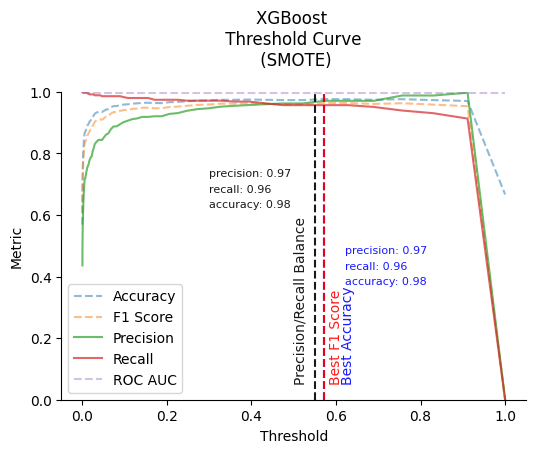

In [ ]:
y_pred = xgb.predict_proba(X_test[fois])

brier_thresholds = []
brier_accs = []
brier_f1s = []
brier_precisions = []
brier_recalls = []
brier_roc_auc = []

for threshold in np.logspace(-4, 0, 100):
    y_pred_thresh = y_pred[:, 1] > threshold
    brier_thresholds.append(threshold)
    brier_accs.append(accuracy_score(y_test, y_pred_thresh))
    brier_f1s.append(f1_score(y_test, y_pred_thresh))
    brier_precisions.append(precision_score(y_test, y_pred_thresh))
    brier_recalls.append(recall_score(y_test, y_pred_thresh))
    brier_roc_auc.append(roc_auc_score(y_test, y_pred[:, 1]))

best_acc_threshold = brier_thresholds[np.argmax(brier_accs)]
best_f1_threshold = brier_thresholds[np.argmax(brier_f1s)]
idx = np.argmax(brier_f1s)

plt.figure(figsize=(6, 4))
plt.plot(brier_thresholds, brier_accs, label="Accuracy", linestyle="--", alpha=0.5)
plt.plot(brier_thresholds, brier_f1s, label="F1 Score", linestyle="--", alpha=0.5)
plt.plot(brier_thresholds, brier_precisions, label="Precision", alpha=0.7)
plt.plot(brier_thresholds, brier_recalls, label="Recall", alpha=0.7)
plt.plot(brier_thresholds, brier_roc_auc, linestyle="--", label="ROC AUC", alpha=0.4)

plt.axvline(x=brier_thresholds[np.argmax(brier_accs)], color=(0, 0, 1, 0.9), linestyle="--")
plt.text(best_acc_threshold+0.04, 0.05, "Best Accuracy", color=(0, 0, 1, 0.9), rotation=90, verticalalignment="bottom")
plt.axvline(x=brier_thresholds[np.argmax(brier_f1s)], color=(1, 0, 0, 0.9), linestyle="--")
plt.text(best_f1_threshold+0.01, 0.05, "Best F1 Score", color=(1, 0, 0, 0.9), rotation=90, verticalalignment="bottom")
plt.axvline(x=0.55, color=(0, 0, 0, 0.9), linestyle="--")
plt.text(0.50, 0.05, "Precision/Recall Balance", color=(0, 0, 0, 0.9), rotation=90, verticalalignment="bottom")


idx = np.argmin(np.abs(np.array(brier_thresholds) - 0.55))
plt.text(0.30, 0.75, "precision: {:.2f}".format(brier_precisions[idx]), color=(0, 0, 0, 0.9), rotation=0, verticalalignment="top", fontsize=8)
plt.text(0.30, 0.70, "recall: {:.2f}".format(brier_recalls[idx]), color=(0, 0, 0, 0.9), rotation=0, verticalalignment="top", fontsize=8)
plt.text(0.30, 0.65, "accuracy: {:.2f}".format(brier_accs[idx]), color=(0, 0, 0, 0.9), rotation=0, verticalalignment="top", fontsize=8)
idx = np.argmax(brier_accs)
plt.text(best_acc_threshold+0.05, 0.50, "precision: {:.2f}".format(brier_precisions[idx]), color=(0, 0, 1, 0.9), rotation=0, verticalalignment="top", fontsize=8)
plt.text(best_acc_threshold+0.05, 0.45, "recall: {:.2f}".format(brier_recalls[idx]), color=(0, 0, 1, 0.9), rotation=0, verticalalignment="top", fontsize=8)
plt.text(best_acc_threshold+0.05, 0.40, "accuracy: {:.2f}".format(brier_accs[idx]), color=(0, 0, 1, 0.9), rotation=0, verticalalignment="top", fontsize=8)

plt.ylim(0, 1)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.xlabel("Threshold")
plt.ylabel("Metric")
plt.title(f"XGBoost \n Threshold Curve \n ({imblearn_})", y=1.06)
plt.legend(loc="lower left")
# plt.grid()
plt.savefig(f"plots/XGBoost_threshold_curve_{imblearn_}.png", bbox_inches="tight", pad_inches=0.2, dpi=300)

In [ ]:
models_performance = save_model_metrics("XGB", "GridSearch", n_folds, [X_train, y_train], [X_test, y_test], grid_xgb, 0.55, models_performance)

# Next

In [ ]:
models_performance

,Model,SearchCV,folds,HyperParams,Train-Accuracy,Test-Accuracy,F1-Score,Recall,Precision,ROC_AUC,mthw_corr,geometric_mean,threshold
0,LogReg,GridSearch,5,"{'C': 4.281332398719396, 'class_weight': 'bala...",0.820519,0.796314,0.695652,0.697674,0.693642,0.857342,0.542598,0.768132,0.56
1,RandomForest,RandomSearch,5,"{'n_estimators': 300, 'min_samples_split': 2, ...",1.000000,0.976722,0.965116,0.965116,0.965116,0.995629,0.947649,0.973786,0.41
2,SVC,RandomSearch,3,"{'probability': True, 'max_iter': 5200, 'kerne...",1.000000,0.965082,0.947674,0.947674,0.947674,0.985681,0.921474,0.960648,0.60
3,XGB,GridSearch,5,"{'learning_rate': 0.2, 'max_depth': 5, 'n_esti...",1.000000,0.972842,0.959184,0.956395,0.961988,0.996213,0.938844,0.968658,0.55


In [ ]:
models_performance.to_csv(f"models_performance_{imblearn_}.csv")

In [ ]:
from google.colab import files
import shutil

shutil.make_archive("plots", 'zip', "plots")
files.download("plots.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

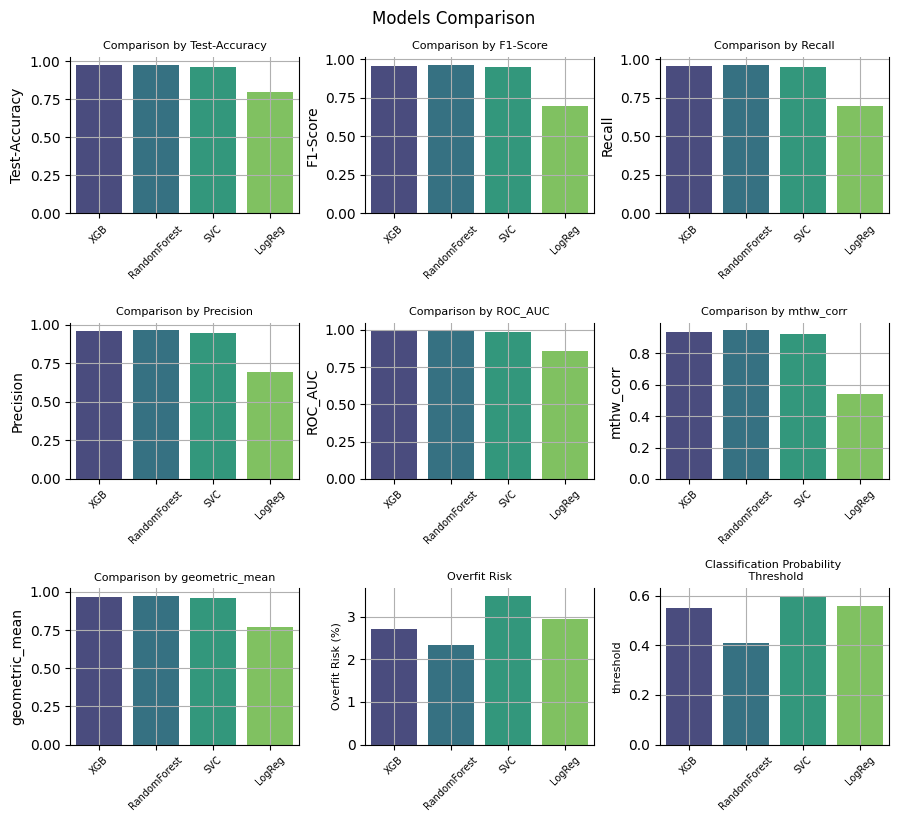

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create the dataframe
df = models_performance

# Compute Overfitting Risk (Train Accuracy - Test Accuracy)
df["Overfit Risk"] = (df["Train-Accuracy"] - df["Test-Accuracy"])/df["Train-Accuracy"]  * 100

# Sort by Test Accuracy
df_sorted = df.sort_values(by="ROC_AUC", ascending=False)

# 📊 PLOT MODEL PERFORMANCE COMPARISON
metrics = ["Test-Accuracy", "F1-Score", "Recall", "Precision", "ROC_AUC", "mthw_corr", "geometric_mean"]
fig = plt.figure(figsize=(9, 8))

for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 3, i)
    sns.barplot(x="Model", y=metric, data=df_sorted, palette="viridis")
    plt.title(f"Comparison by {metric}", fontsize=8)
    plt.xticks(rotation=45, fontsize=7)
    plt.xlabel("")
    plt.gca().spines["top"].set_visible(False)
    plt.grid()

plt.subplot(3, 3, i+1)
sns.barplot(x="Model", y="Overfit Risk", data=df_sorted, palette="viridis")
plt.title("Overfit Risk", fontsize=8)
plt.xticks(rotation=45, fontsize=7)
plt.ylabel("Overfit Risk (%)", fontsize=8)
plt.xlabel("")
plt.gca().spines["top"].set_visible(False)
plt.grid()

plt.subplot(3, 3, i+2)
sns.barplot(x="Model", y="threshold", data=df_sorted, palette="viridis")
plt.title("Classification Probability \n Threshold", fontsize=8)
plt.xticks(rotation=45, fontsize=7)
plt.ylabel("threshold", fontsize=8)
plt.xlabel("")
plt.gca().spines["top"].set_visible(False)
plt.grid()

plt.tight_layout()
fig.suptitle("Models Comparison", y=1.02)
plt.show()

# 🔍 Print sorted results
# print("\n📊 Sorted Model Performance (by Test Accuracy):")
# print(df_sorted[["Model", "Test-Accuracy", "F1-Score", "Recall", "Precision", "ROC_AUC", "Overfit Risk"]])
fig.savefig("plots/model_comparison.png", dpi=300)